# Plot figure 2

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
# figure configuration
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")

## Data preparation

### Create dictionaries with json files and geojson folders

In [3]:
# get the directory with downloaded data
os.chdir("..")
home_dir = os.getcwd()
data_dir = os.path.join(home_dir, "downloaded-data")


In [4]:
# create dictionary with json files
json_names = []
for (dir_path, dir_names, file_names) in os.walk(data_dir):
    json_names.extend(file_names)
print(json_names)

json_names.sort()

pattern = re.compile(r"^roads.+")
json_dic = {k: v for (k,v) in zip(range(len(json_names)), json_names) if pattern.match(v)}
json_dic

['blds_africa_states_18-23_ai.json', 'blds_continent_data_18-23_ai.json', 'blds_northamerica_states_18-23_ai.json', 'roads_asia_states_18-23_ai.json', 'roads_continent_data_18-23_ai.json', 'roads_europe_states_18-23_ai.json']


{3: 'roads_asia_states_18-23_ai.json',
 4: 'roads_continent_data_18-23_ai.json',
 5: 'roads_europe_states_18-23_ai.json'}

In [5]:
# create list of folders with geojson files
geojson_folder_lst = []
for (dir_path, dir_names, file_names) in os.walk(home_dir):  # give the path
    for dir_name in dir_names:
        # print(dir_name)
        pattern = re.compile(r"^geojson.+states$")
        
        if pattern.match(dir_name):
            # print(dir_name)
            geojson_folder_lst.append(dir_name)
geojson_folder_lst


['geojson-africa-states',
 'geojson-asia-states',
 'geojson-continent-states',
 'geojson-europe-states',
 'geojson-northamerica-states']

In [6]:
# create location list from json files
location_lst = []
for _json in json_dic.values():
    match = re.search(r"(?<=_)[^_]+(?=_)",
                      _json)
    if match:
        substring = match.group(0)
        print(substring)
        location_lst.append(substring)
location_lst

asia
continent
europe


['asia', 'continent', 'europe']

In [7]:
# create a a list with the selection of geojson folders
sel_geojson_folder_lst = []
for location in location_lst:
    # print(location)
    for folder in geojson_folder_lst:
        # print(folder)
        if location in folder:
            sel_geojson_folder_lst.append(folder)
sel_geojson_folder_lst.sort()


In [8]:
sel_geojson_folder_lst


['geojson-asia-states', 'geojson-continent-states', 'geojson-europe-states']

In [9]:
# create final geojson_folder_dic according to the json_dic
geojson_folder_dic = {k: v for (k, v) in zip(json_dic.keys(), sel_geojson_folder_lst)}
geojson_folder_dic


{3: 'geojson-asia-states',
 4: 'geojson-continent-states',
 5: 'geojson-europe-states'}

### Definitions

In [10]:
# user input definition

while True:
    user_d_spec = input(f"Which data do you want to plot?\
                            Enter the number of the json file:\n\
                            {json_dic}"
                        )
    try:
        user_d_spec = int(user_d_spec)
    except ValueError:
        print(f"You wrote: {user_d_spec}, please enter a number.")
        continue
    if user_d_spec not in json_dic.keys():
        print(
            f"You wrote: {user_d_spec}, please enter one of these numbers: {json_dic.keys()}.")
        continue
    break


In [11]:
# function definitions

def data_spec(data_dic):
    
    try:
        with open(f"downloaded-data\\{data_dic[user_d_spec]}", "r") as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(e)
        print("Please download the data first.")


def get_geojson_names(home_dir, geojson_folder_dic):
    
    geojson_dir = os.path.join(home_dir, geojson_folder_dic[user_d_spec], "")

    geojson_names = []
    for (dir_path, dir_names, file_names) in os.walk(geojson_dir):  # give the path
        geojson_names.extend(file_names)
    print(geojson_names)
    return geojson_names


### Load the data

In [12]:
data = data_spec(json_dic)


### Edit the obtained data into desired shape to create a DataFrame

In [13]:
d = {
    "feature": [],
    "source": [],
    "timestamp": [],
    "value": []
}


In [14]:
for cont in data:
    for dic1 in cont:
        feature, source = dic1["groupByObject"][0], dic1["groupByObject"][1]
        for res in dic1["result"]:
            d["feature"].append(feature)
            d["source"].append(source)
            d["timestamp"].append(res["timestamp"])
            d["value"].append(res["value"])

df = pd.DataFrame(d)
# df

In [15]:
# extract only the year
df["year"] = pd.to_datetime(df["timestamp"]).dt.year

### Append the names of the regions to the DataFrame

In [16]:
# extract the geojson IDs and the names
geojson_names = get_geojson_names(home_dir, geojson_folder_dic)


['0_Africa.geojson', '1_Asia.geojson', '2_Australia.geojson', '3_North America.geojson', '4_Oceania.geojson', '5_South America.geojson', '6_Antarctica.geojson', '7_Europe.geojson']


In [17]:
geojson_names_2 = geojson_names
# using lib RegularExpression to separate the ID number and the state name
id_name_dic = {int(re.search(r'^\d+', k)[0]): re.search(r'\_.+\.', v)[0][1:-1]
                for k, v in zip(geojson_names, geojson_names_2)}
id_name_ser = pd.Series(id_name_dic)
id_name_df = pd.DataFrame(id_name_ser, columns=["name"])
id_name_df = id_name_df.reset_index().rename(columns={"index": "id"})
id_name_df["id"] = id_name_df["id"].astype(int)
# id_name_df


In [18]:
# merge df with region names based on ids
df = df.merge(id_name_df, how="left", left_on="feature",
               right_on="id")
# df.head()

### Filtering the data

In [ ]:
# exclude states which give zero in total
df = df.groupby("name").filter(
    lambda x: x["value"].sum() != 0)

In [19]:
# get the length of AI Microsoft (source=maxar) / manually mapped (remainder) roads for every year
grouped = df.groupby(["source", "year"])["value"].sum()
# grouped


In [20]:
# merge the DataFrame with groupBy DataFrame and compute the percentage
merged_data = df.merge(grouped, on=["source", 'year'], how='left', )
merged_data = merged_data.rename(columns={"value_x":"len_of_roads", "value_y":"total_roads"})
merged_data["percentage"] = (merged_data["len_of_roads"] / merged_data["total_roads"]) * 100
# merged_data.head(10)


In [21]:
# percentage verification
merged_data.groupby(["source", "year"])["percentage"].sum()


source        year
remainder     2018    100.0
              2019    100.0
              2020    100.0
              2021    100.0
              2022    100.0
              2023    100.0
source=maxar  2018      0.0
              2019      0.0
              2020    100.0
              2021    100.0
              2022    100.0
              2023    100.0
Name: percentage, dtype: float64

In [22]:
# create the dataframe by the source
# remainder = manually mapped roads
df_rem = merged_data.loc[(merged_data["source"] == "remainder"), :]
# buiildings used from Microsoft AI
df_ai = merged_data.loc[(merged_data["source"] == "source=maxar"), :]
# df_ai.head()


In [23]:
# exclude states which give zero in total
# df_rem = df_rem.groupby("name").filter(lambda x: x["len_of_roads"].sum() != 0)
# df_ai = df_ai.groupby("name").filter(lambda x: x["len_of_roads"].sum() != 0)


In [24]:
# verify the sum
# df_rem.groupby("name")["len_of_roads"].sum().sort_values(ascending=True)


In [25]:
# verify the sum
# df_ai.groupby("name")["len_of_roads"].sum().sort_values(ascending=True)

In [26]:
# how the DataFrame looks like – manually mapped roads
df_rem.head()

,feature,source,timestamp,len_of_roads,year,id,name,total_roads,percentage
0,0,remainder,2018-01-01T00:00:00Z,5.454454e+09,2018,0,Africa,5.037323e+10,10.828081
1,0,remainder,2019-01-01T00:00:00Z,6.470871e+09,2019,0,Africa,5.478630e+10,11.811113
2,0,remainder,2020-01-01T00:00:00Z,7.902788e+09,2020,0,Africa,5.952437e+10,13.276557
3,0,remainder,2021-01-01T00:00:00Z,8.821002e+09,2021,0,Africa,6.465945e+10,13.642247
4,0,remainder,2022-01-01T00:00:00Z,9.619285e+09,2022,0,Africa,6.819191e+10,14.106197


In [27]:
# how the DataFrames look like – AI Microsoft roads
df_ai.head()

,feature,source,timestamp,len_of_roads,year,id,name,total_roads,percentage
6,0,source=maxar,2018-01-01T00:00:00Z,0.000000e+00,2018,0,Africa,0.000000e+00,NaN
7,0,source=maxar,2019-01-01T00:00:00Z,0.000000e+00,2019,0,Africa,0.000000e+00,NaN
8,0,source=maxar,2020-01-01T00:00:00Z,9.156849e+05,2020,0,Africa,1.430082e+06,64.030259
9,0,source=maxar,2021-01-01T00:00:00Z,4.286408e+07,2021,0,Africa,3.193565e+08,13.422016
10,0,source=maxar,2022-01-01T00:00:00Z,2.080913e+08,2022,0,Africa,1.415734e+09,14.698476


## Plots

### Manually mapped roads

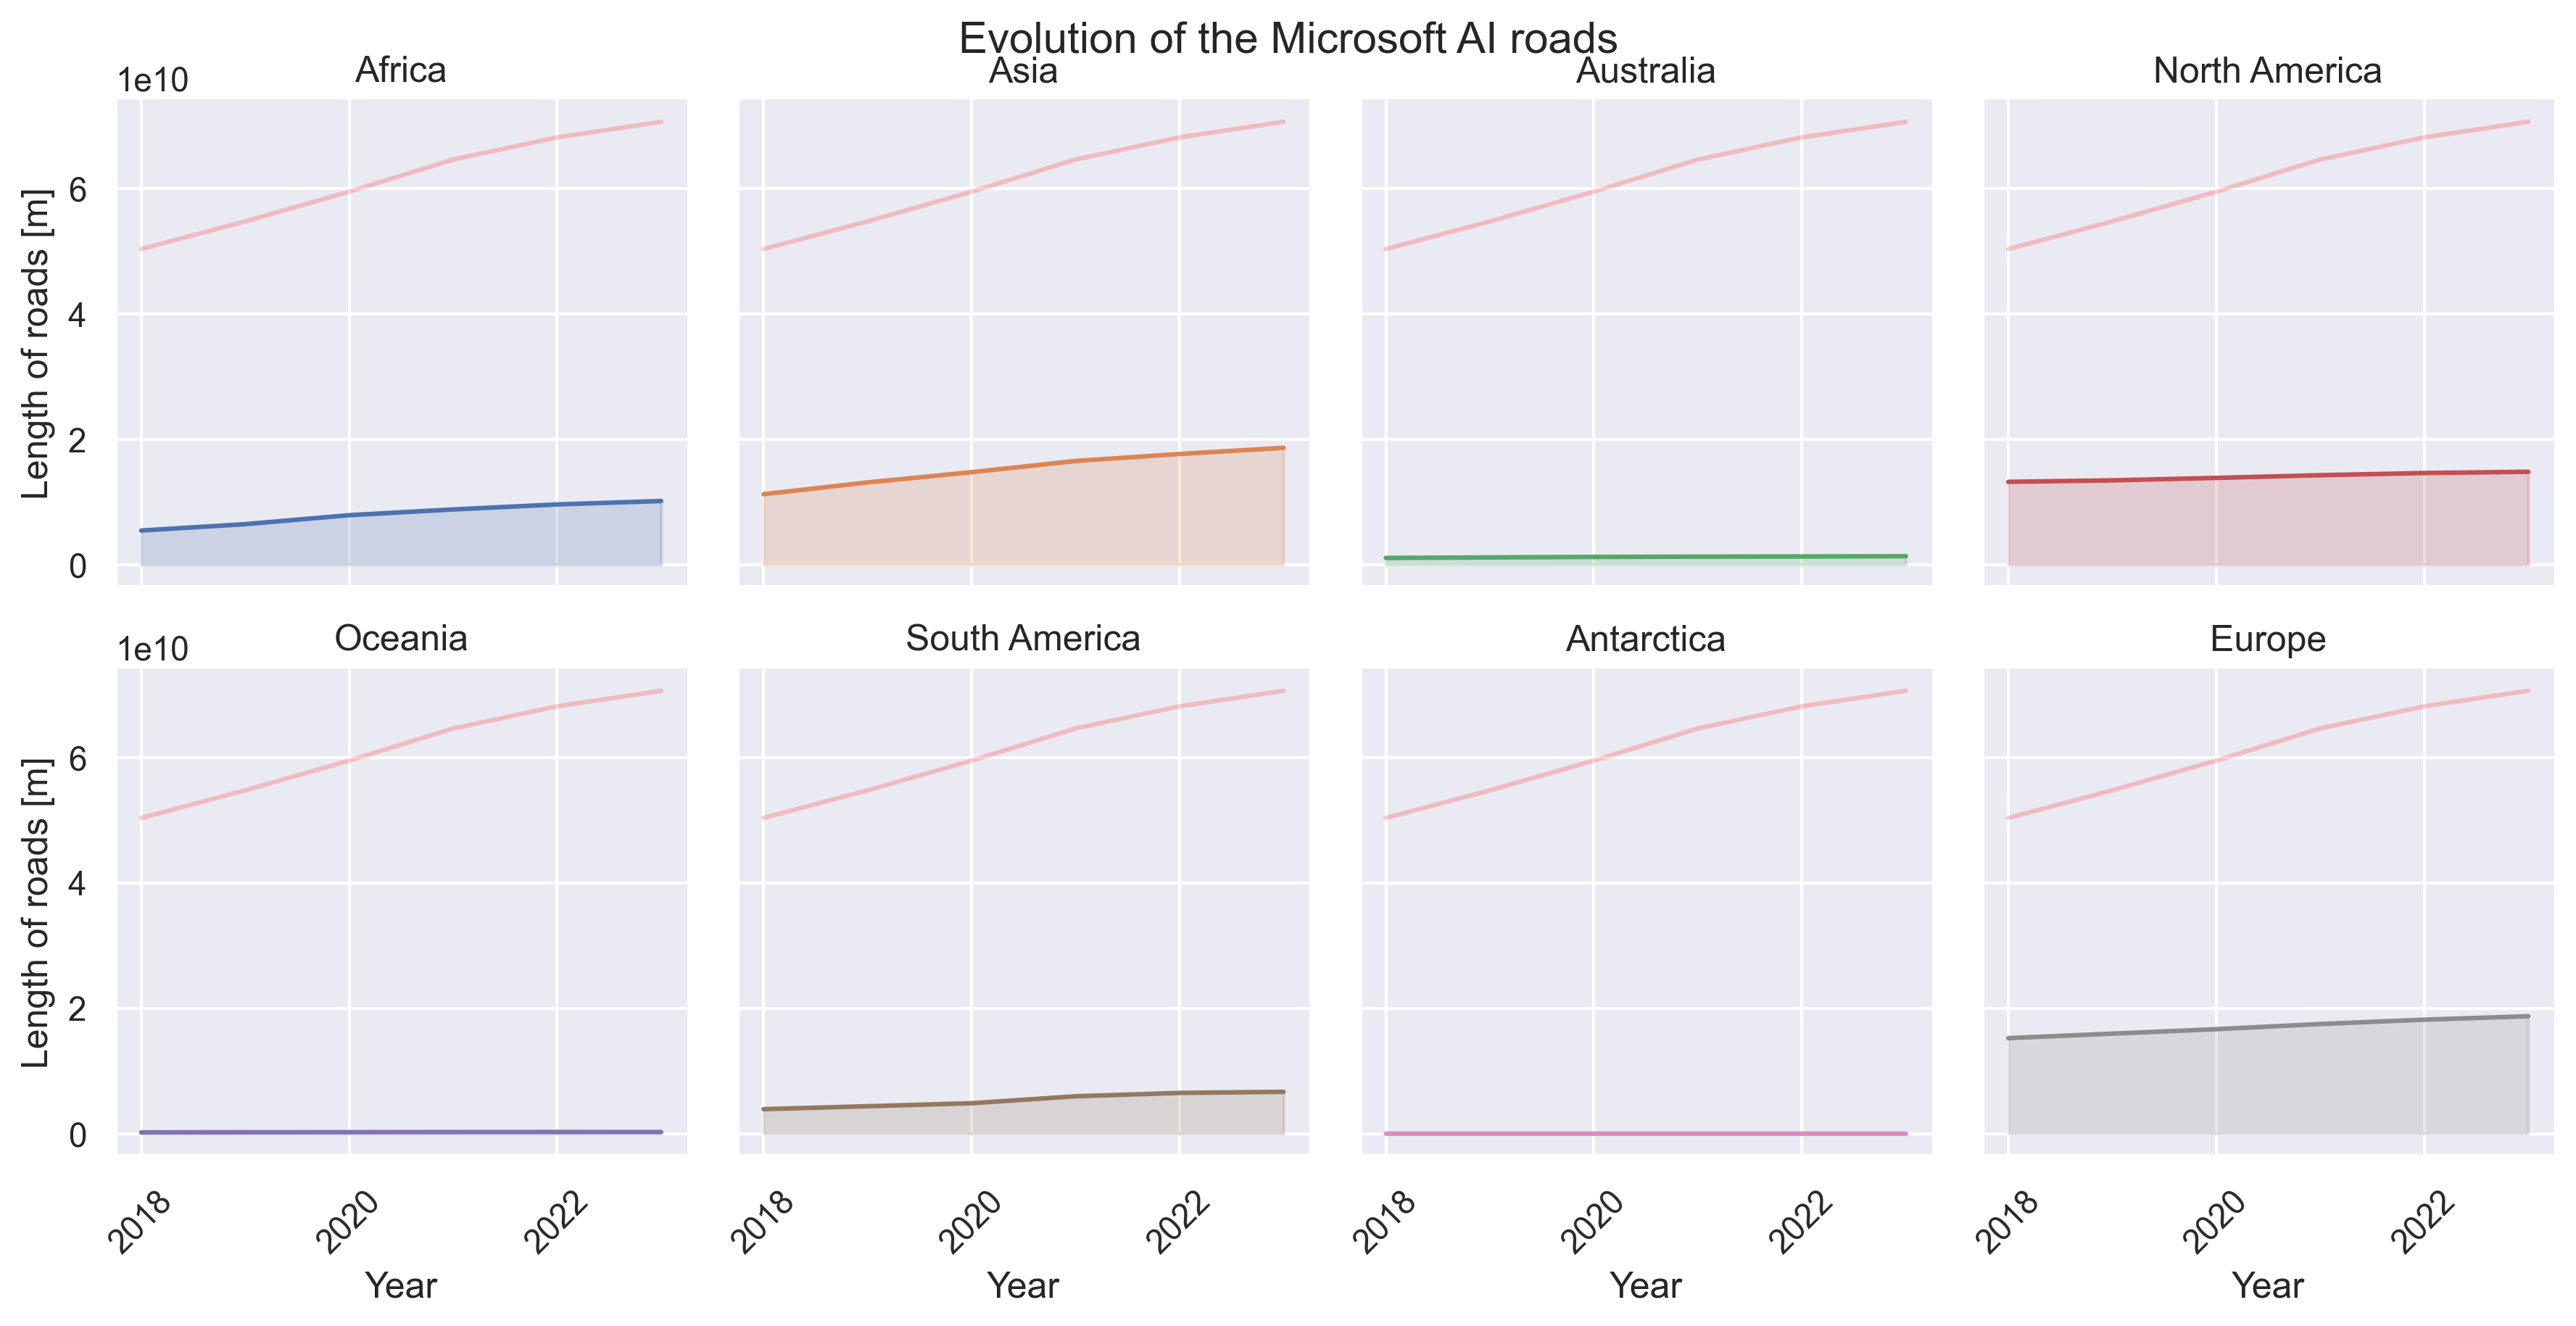

In [28]:
# create a grid : initialize it
g = sns.FacetGrid(df_rem, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'len_of_roads')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'len_of_roads',
          alpha=0.2)

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_roads', color='red', alpha=0.2)

# # fill the area with fill_between
# g = g.map(plt.fill_between, 'year', 'total_roads',
#           alpha=0.2)

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI roads')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# show the graph
plt.show()


#### Try to add summary plot

In [ ]:
df_rem_tot = df_rem.groupby("year")["total_roads"].last().reset_index()
df_rem_tot

,year,total_roads
0,2018,1.318454e+10
1,2019,1.517844e+10
2,2020,1.694888e+10
3,2021,1.890248e+10
4,2022,2.013083e+10
5,2023,2.119682e+10


C:\Users\milan\AppData\Local\Temp\ipykernel_9016\2705569988.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(11, 6, 66)
C:\Users\milan\AppData\Local\Temp\ipykernel_9016\2705569988.py:42: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


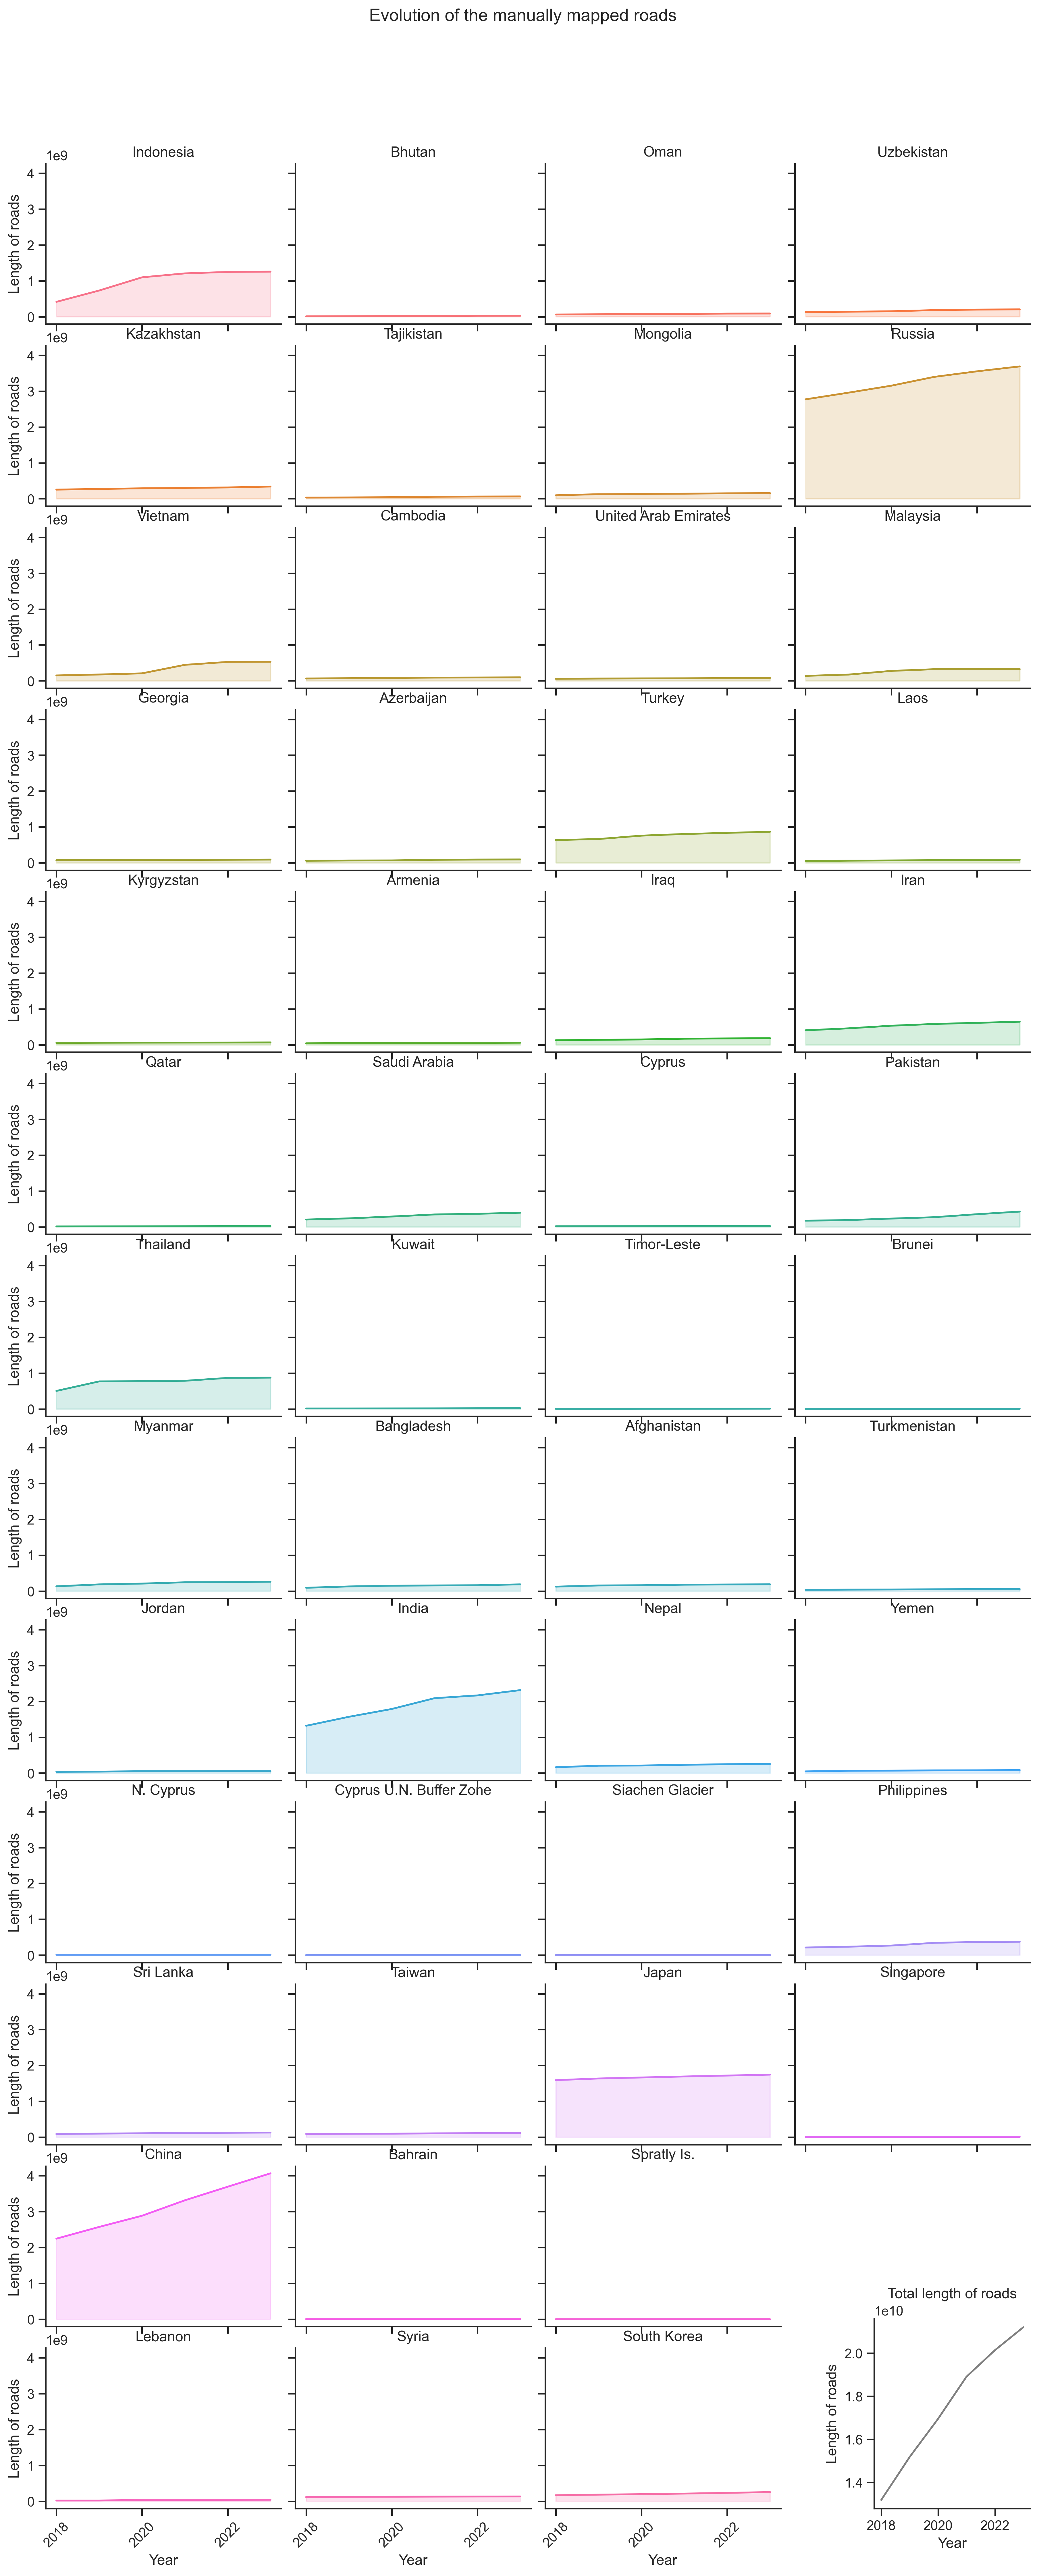

In [ ]:
# create a FacetGrid for the first dataframe
g = sns.FacetGrid(df_rem, col='name', hue='name',
                  col_wrap=4, height=4, aspect=1.2)

# plot the data on the FacetGrid
g = g.map(plt.plot, 'year', 'len_of_roads')
g = g.map(plt.fill_between, 'year', 'len_of_roads', alpha=0.2)

# set the x-axis labels to be rotated
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set the titles for each subplot based on the 'name' column
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the manually mapped roads')

# set the axes titles and limits
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# create a new plot axis for the second dataframe
ax2 = plt.subplot(11, 6, 66)

# plot the data from the second dataframe on the new axis
sns.lineplot(data=df_rem_tot, x='year',
             y='total_roads', color='black', alpha=0.5)

# set the title and axes labels for the new plot axis
ax2.set_title('Total length of roads [m]')
ax2.set_xlabel('Year')
ax2.set_ylabel('Length of roads')

# remove the top and right spines of all subplots
sns.despine()

# adjust the layout of the subplots
plt.tight_layout()

# adjust the size of the figure
fig = plt.gcf()
fig.set_size_inches(12, 30)

# show the plot
plt.show()


### AI Microsoft roads

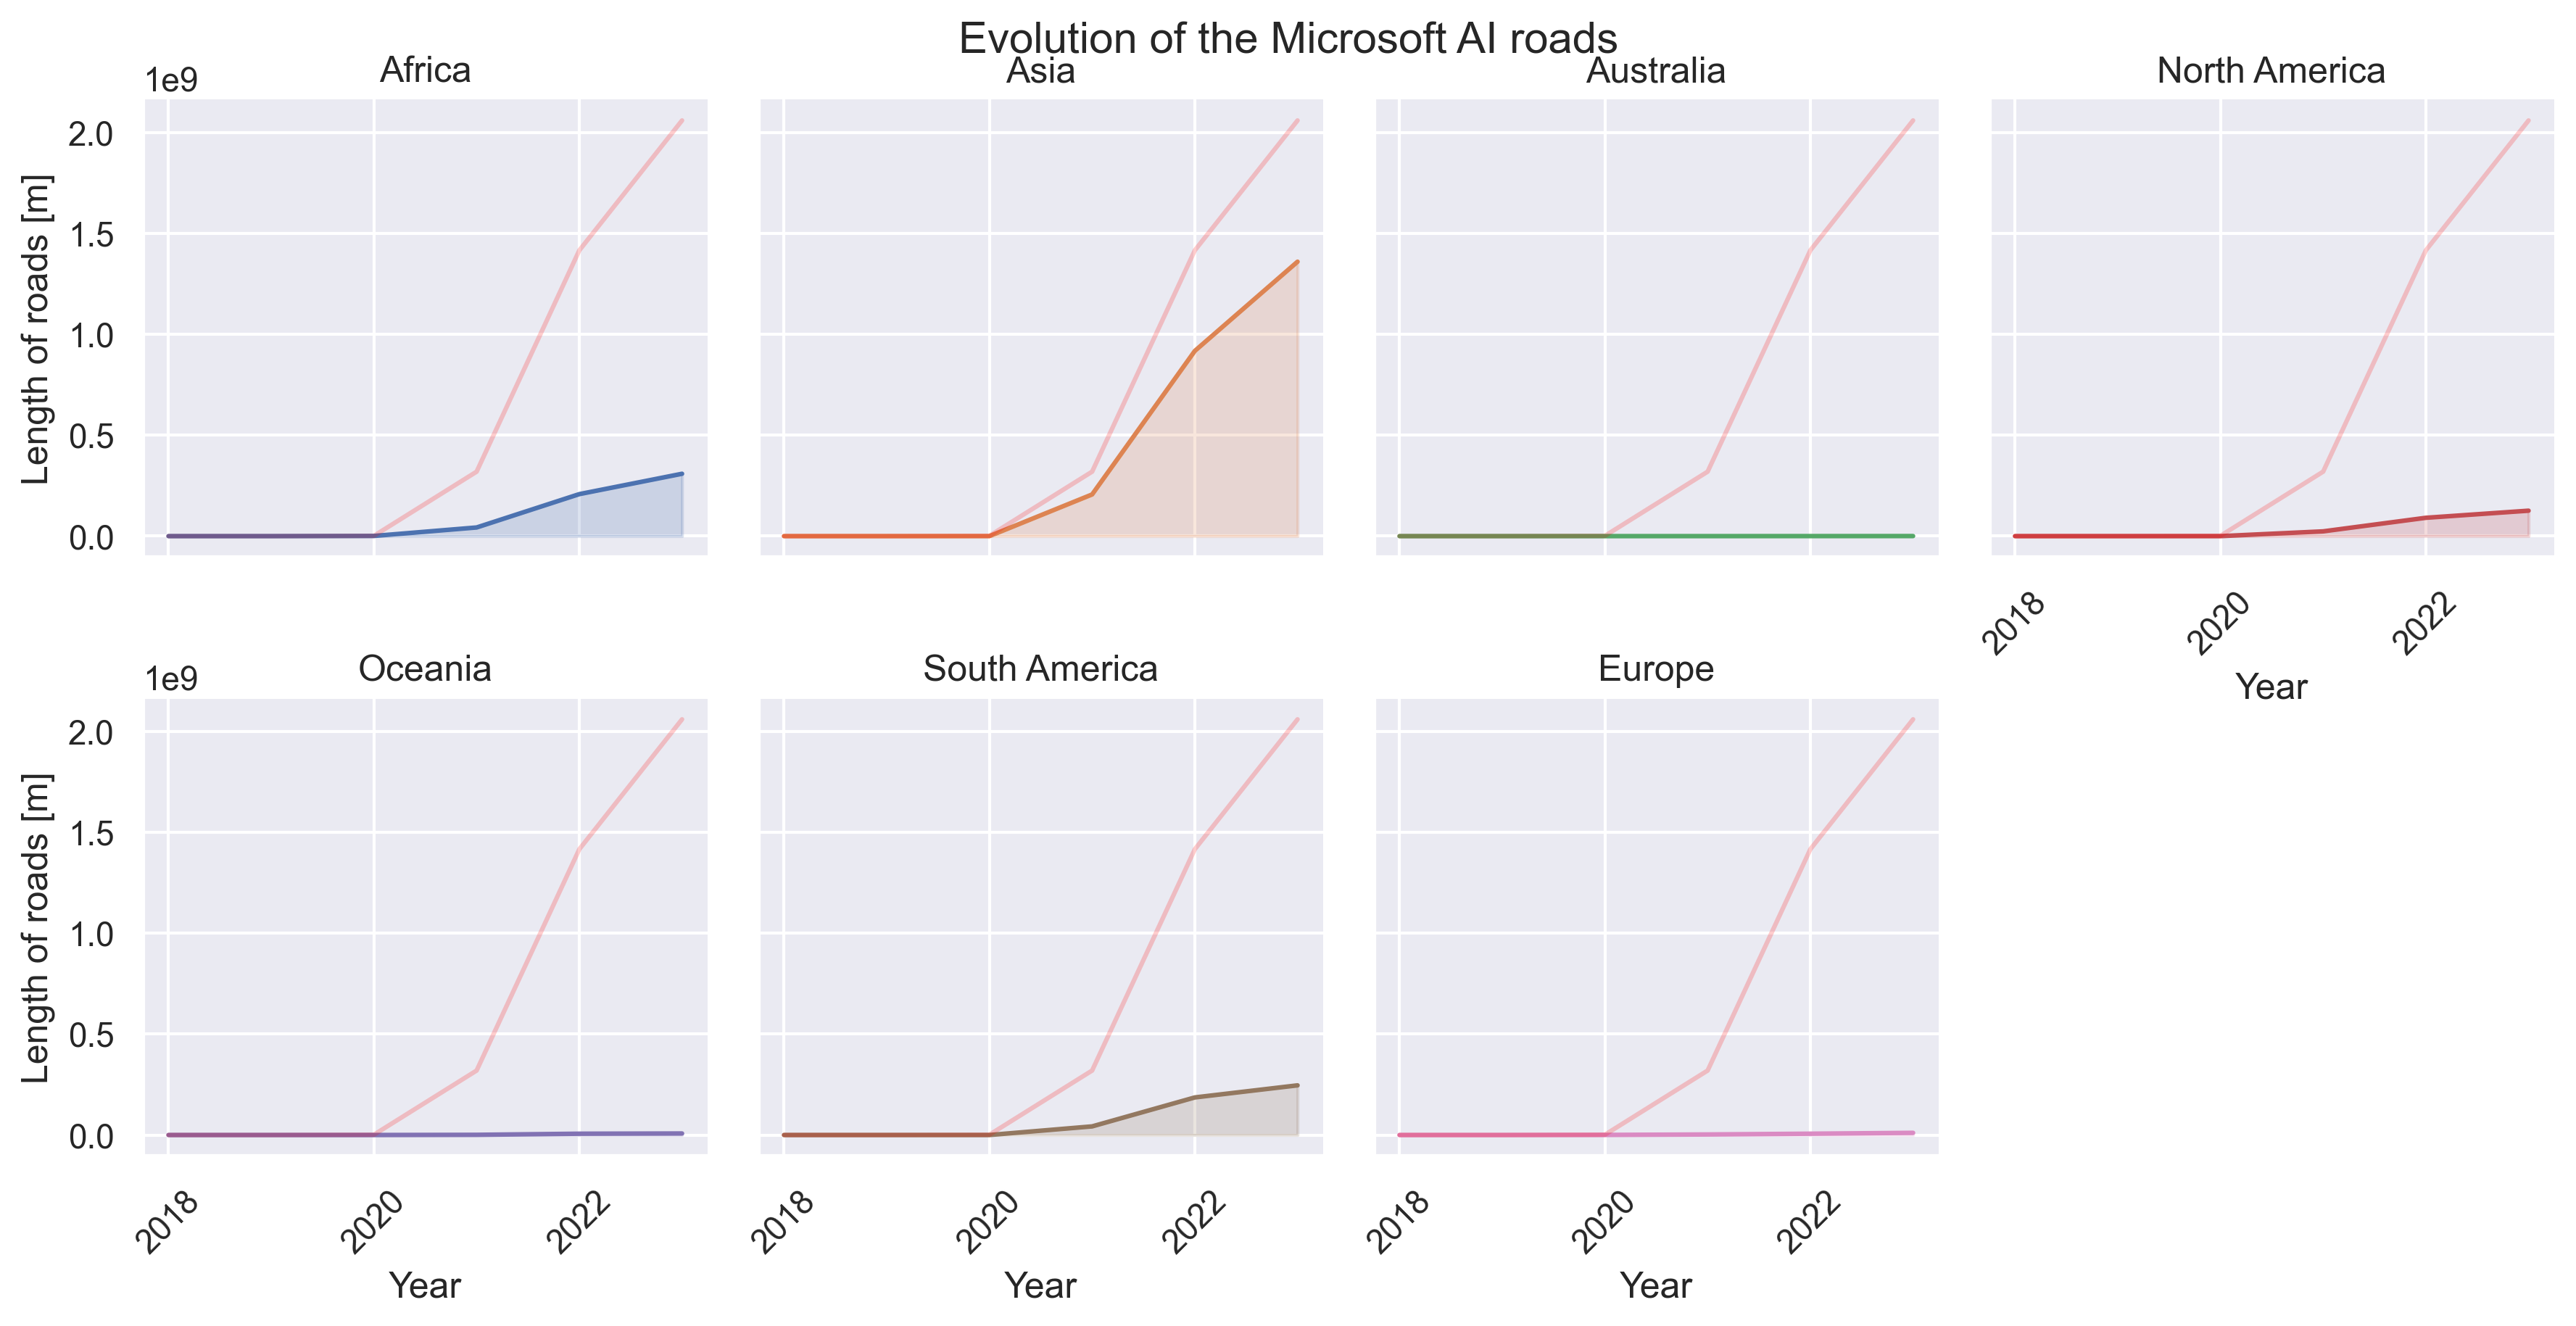

In [29]:
# create a grid : initialize it
g = sns.FacetGrid(df_ai, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'len_of_roads')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'len_of_roads',
          alpha=0.2)

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_roads', color='red', alpha=0.2)

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI roads')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# show the graph
plt.show()


#### Try to add summary plot

In [ ]:
df_ai_tot = df_ai.groupby("year")["total_roads"].last().reset_index()
df_ai_tot

,year,total_roads
0,2018,1.318454e+10
1,2019,1.517844e+10
2,2020,1.694888e+10
3,2021,1.890248e+10
4,2022,2.013083e+10
5,2023,2.119682e+10


C:\Users\milan\AppData\Local\Temp\ipykernel_9016\3609520337.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(11, 6, 66)
C:\Users\milan\AppData\Local\Temp\ipykernel_9016\3609520337.py:42: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


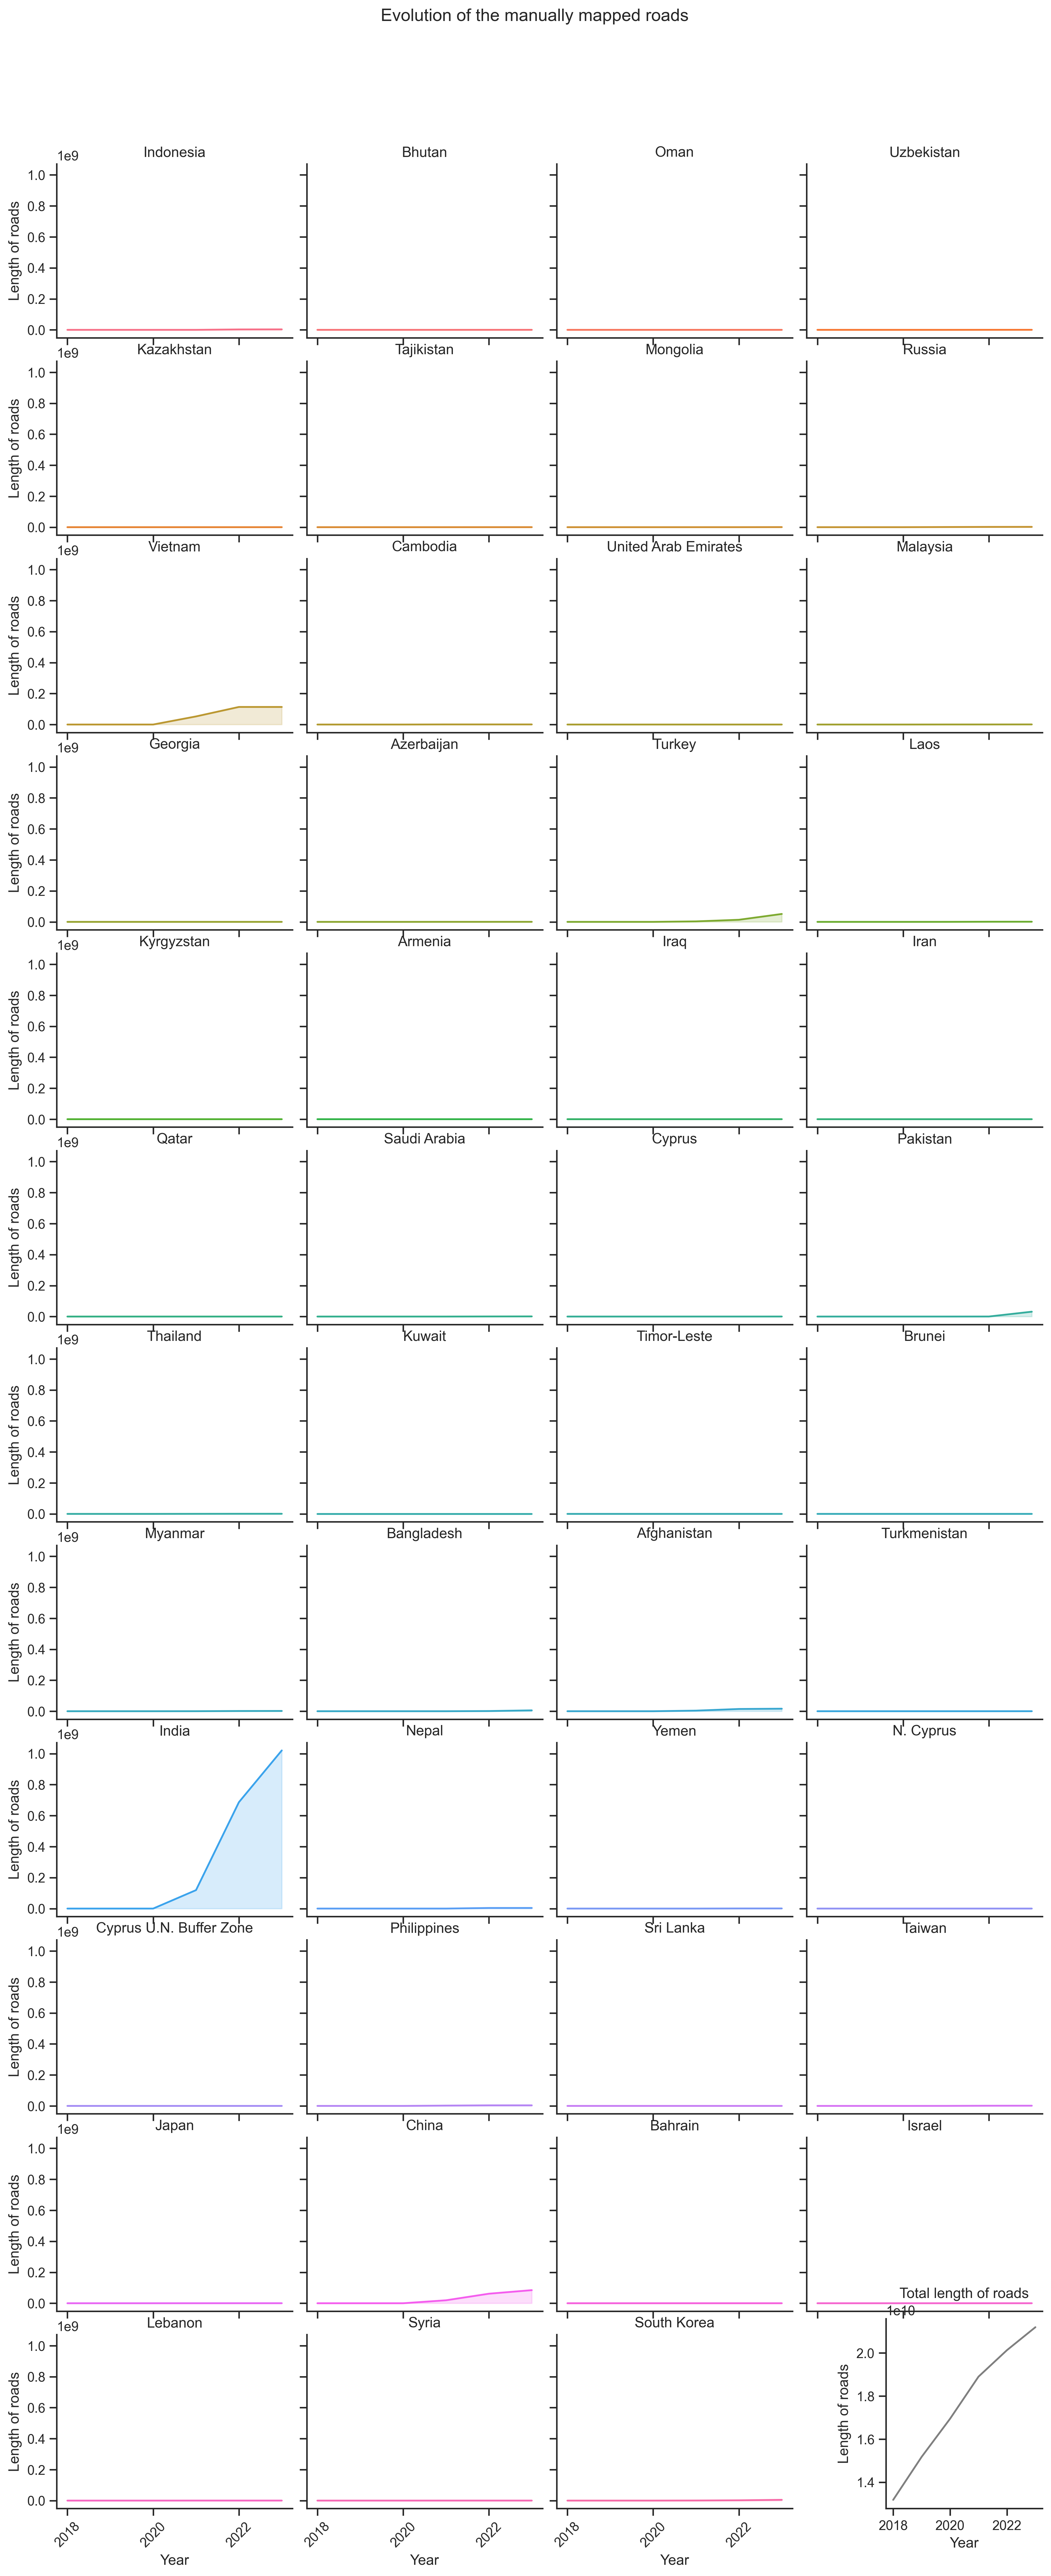

In [ ]:
# create a FacetGrid for the first dataframe
g = sns.FacetGrid(df_ai, col='name', hue='name',
                  col_wrap=4, height=4, aspect=1.2)

# plot the data on the FacetGrid
g = g.map(plt.plot, 'year', 'len_of_roads')
g = g.map(plt.fill_between, 'year', 'len_of_roads', alpha=0.2)

# set the x-axis labels to be rotated
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set the titles for each subplot based on the 'name' column
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI roads')

# set the axes titles and limits
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# create a new plot axis for the second dataframe
ax2 = plt.subplot(11, 6, 66)

# plot the data from the second dataframe on the new axis
sns.lineplot(data=df_ai_tot, x='year',
             y='total_roads', color='black', alpha=0.5)

# set the title and axes labels for the new plot axis
ax2.set_title('Total length of roads [m]')
ax2.set_xlabel('Year')
ax2.set_ylabel('Length of roads')

# remove the top and right spines of all subplots
sns.despine()

# adjust the layout of the subplots
plt.tight_layout()

# adjust the size of the figure
fig = plt.gcf()
fig.set_size_inches(12, 30)

# show the plot
plt.show()


### AI Microsoft and Manually mapped rods together

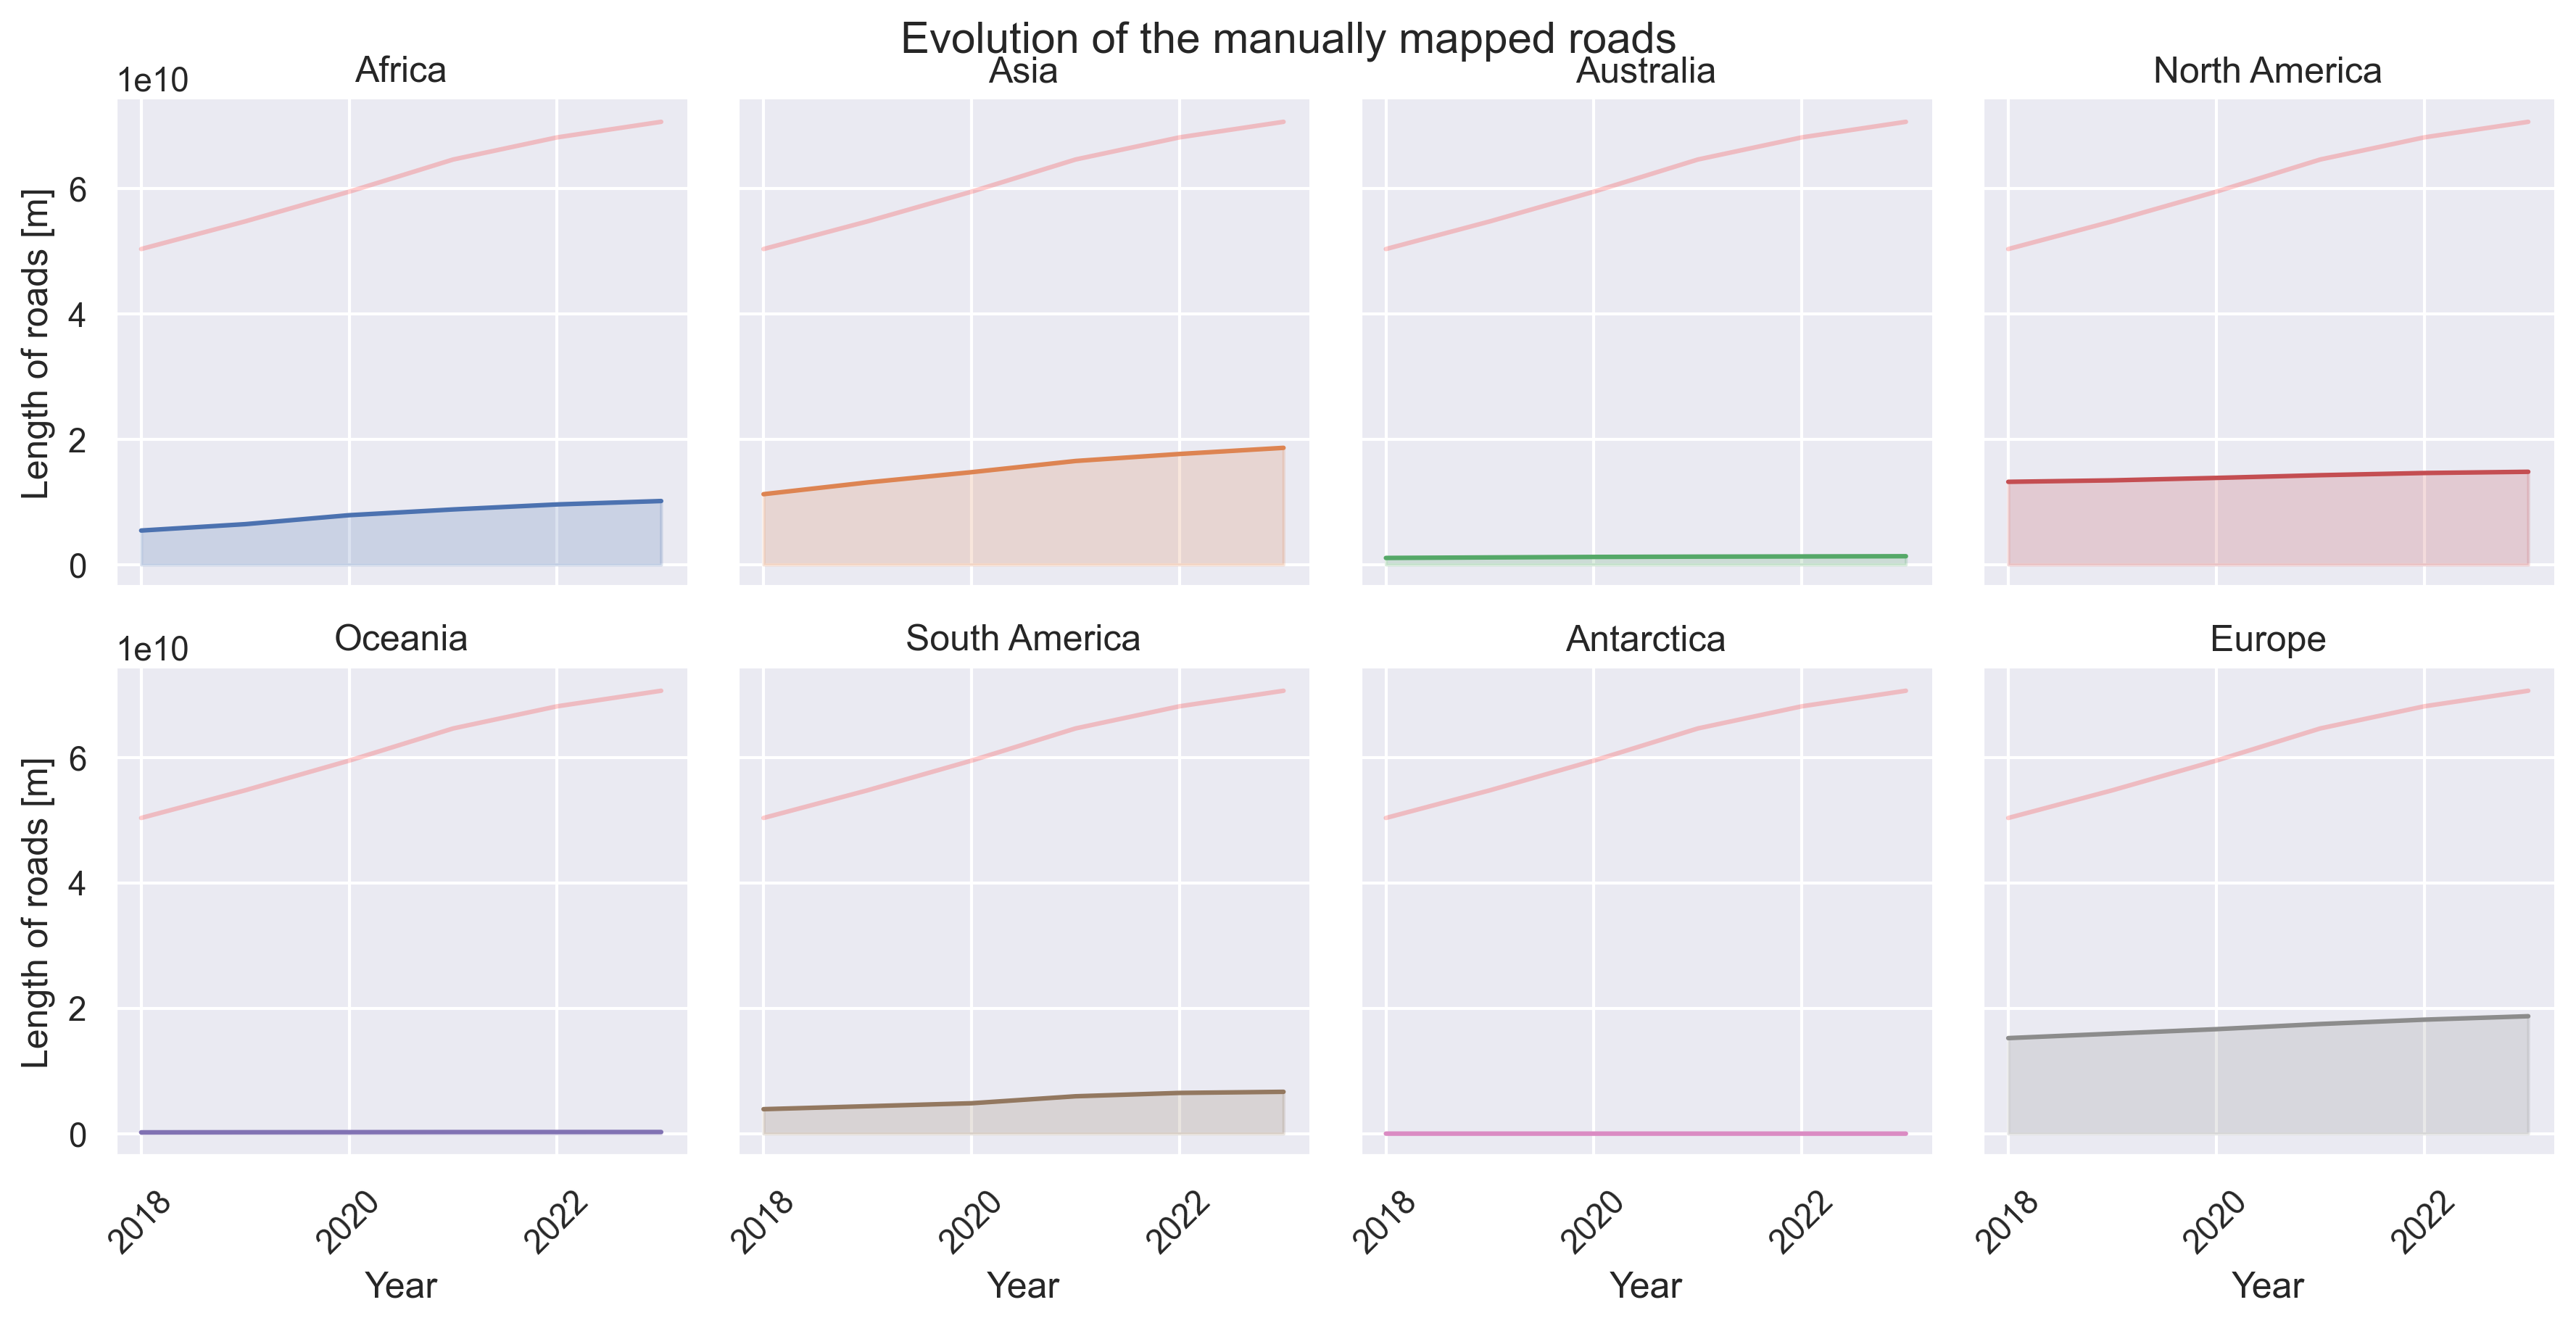

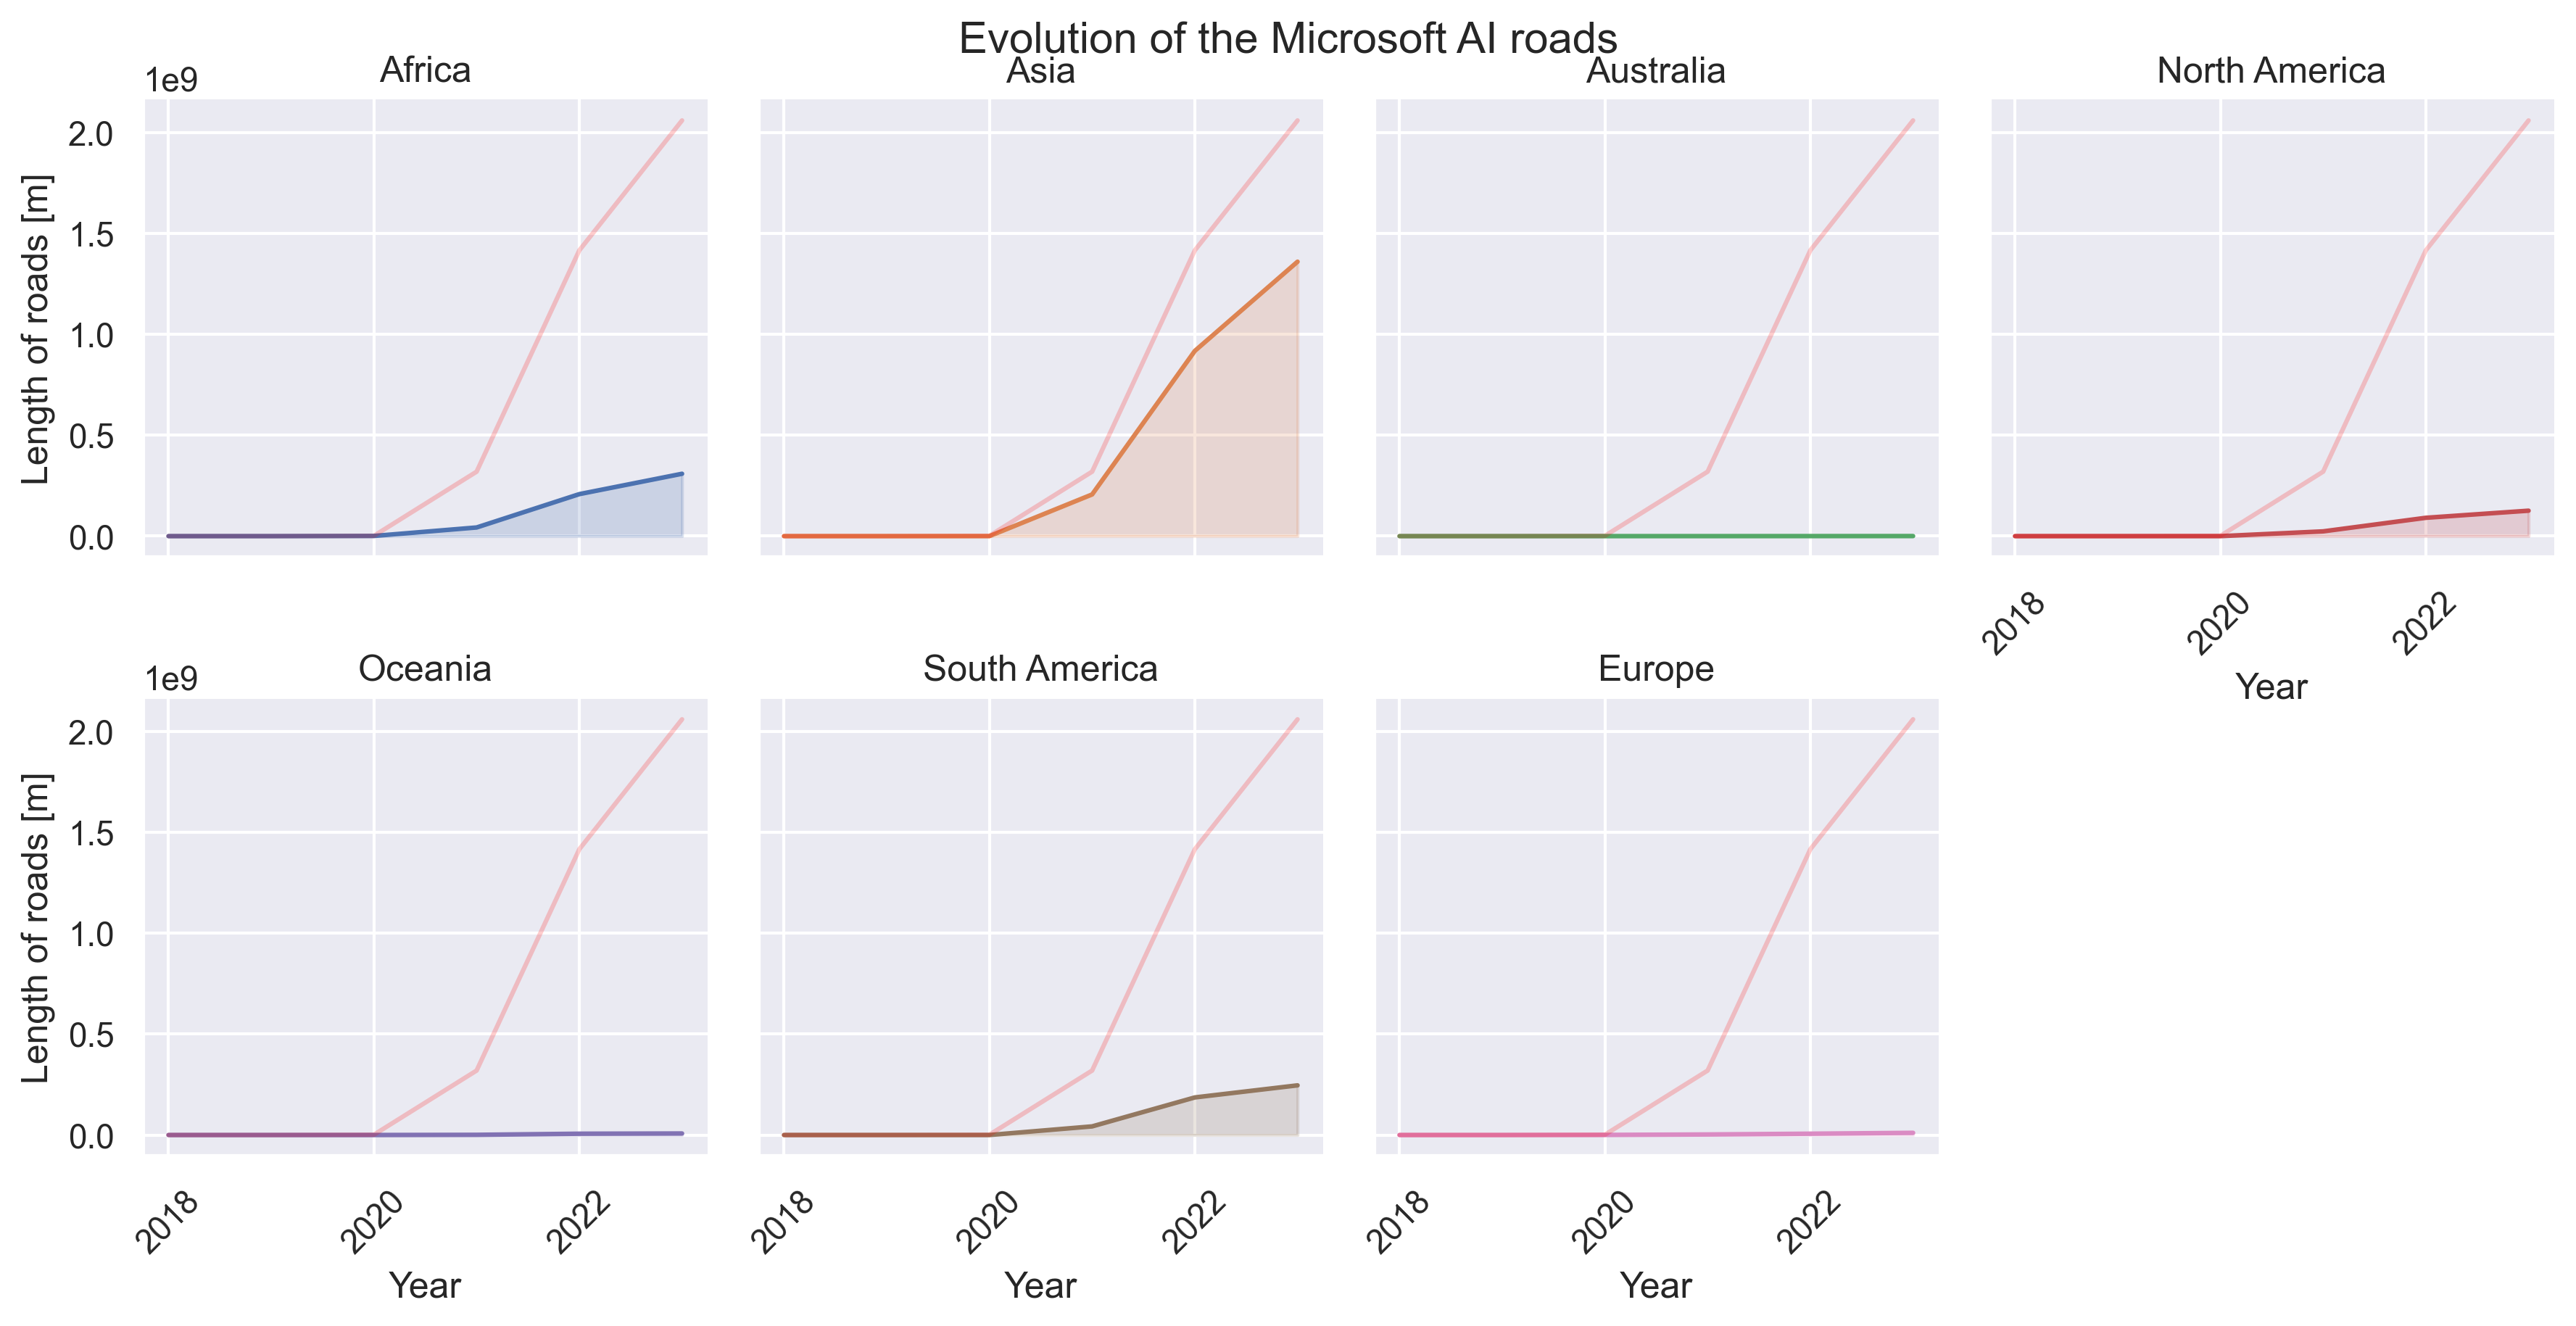

In [30]:
# create a grid : initialize it
g = sns.FacetGrid(df_rem, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'len_of_roads')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'len_of_roads',
          alpha=0.2)#.set_titles("{col_name}")

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_roads', color='red', alpha=0.2)

# g.set(ylim=(0, 100))

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the manually mapped roads')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")
    # ax.set_ylim(100)

# Show the graph
plt.show()


# create a grid : initialize it
g = sns.FacetGrid(df_ai, col='name', hue='name', col_wrap=4, )

# add the line over the area with the plot function
g = g.map(plt.plot, 'year', 'len_of_roads')

# fill the area with fill_between
g = g.map(plt.fill_between, 'year', 'len_of_roads',
          alpha=0.2)  # .set_titles("{col_name}")

# plot the sum line over the plot
g = g.map(plt.plot, 'year', 'total_roads', color='red', alpha=0.2)

# g.set(ylim=(0,100))

# rotate the xticklabels
[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set subtitles using the get_subtitle function
g.set_titles("{col_name}")

# add a title for the whole plot
plt.subplots_adjust(top=0.92)
g.fig.suptitle('Evolution of the Microsoft AI roads')

# set the axes titles
axes = g.axes.flatten()
for ax in axes:
    ax.set_xlabel("Year")
    ax.set_ylabel("Length of roads [m]")

# show the graph
plt.show()
